In [71]:
import csv
import math
import json
import os
import cv2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [20]:
path = os.getcwd()
dataset_path = os.path.join(os.getcwd(), "dataset/Annotations")
image_path = os.path.join(os.getcwd(), "dataset/JPEGImages")

train_path = os.path.join(dataset_path, "pascal_train2007.json")
val_path = os.path.join(dataset_path, "pascal_val2007.json")

# building up training dataset
with open(train_path) as f:
    train_data = json.load(f)

train_dataset = []
for image in train_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in train_data["annotations"]:
        if anno["image_id"] == image['id']:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    train_dataset.append(image_set)


# building up validation dataset    
with open(val_path) as f:
    val_data = json.load(f)
    
val_dataset = []
for image in val_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in val_data["annotations"]:
        if anno["image_id"] == image["id"]:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    val_dataset.append(image_set)

# redistribute list
combine_list = train_dataset + val_dataset
train_dataset = combine_list[:int(len(combine_list) * 0.8)]
val_dataset = combine_list[int(len(combine_list) * 0.8):]
    
# converter to convert id to label name
id_to_name = {c['id']:c['name'] for c in train_data['categories']}

print("train_dataset: {}".format(len(train_dataset)))
print("val_dataset: {}".format(len(val_dataset)))
print(train_data.keys())
print()
print("images: {}\n".format(train_data['images'][0]))
print("annotations: {}\n".format(train_data['annotations'][0]))
print("categories: {}\n".format(train_data['categories'][0]))

train_dataset: 4008
val_dataset: 1003
dict_keys(['images', 'type', 'annotations', 'categories'])

images: {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

annotations: {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}

categories: {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}



In [50]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_img(im, figsize=(10, 10), ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    return ax

def load_image(path):
    img = cv2.imread(path, 1) 
    return img[..., ::-1]

def onehot_to_label(labels):
    idx = [idx for idx, l in enumerate(labels) if l == 1.0][0]
    return id_to_name.get(idx)

### Image Augmentation

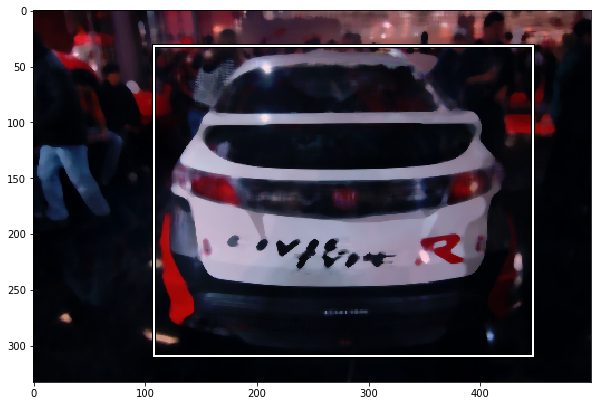

In [4]:
import imgaug as ia
from imgaug import augmenters as iaa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = train_dataset[19]
img_path = os.path.join(image_path, data["image"]['file_name'])

ori_img = Image.open(img_path)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 0.5), n_segments=(100, 300))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
#                 sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                 sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                 sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

bbox = data['annotation']["bbox"]
img = seq.augment_image(np.array(ori_img))

ax = show_img(img)
draw_rect(ax, bbox)

In [79]:
# https://github.com/lars76/object-localization/blob/master/example_2/train.py
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.0

# training parameters
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = True
THREADS = 3
NUM_CLASSES = 20

class DataGenerator(Sequence):

    def __init__(self, dataset, is_augmentated=False):
        self.is_augmentated = is_augmentated
        self.paths = []
        self.coords = np.zeros((len(dataset), 4 + NUM_CLASSES))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            width = data["image"]["width"]
            height = data["image"]["height"]
        
            x_scale = IMAGE_SIZE / width
            y_scale = IMAGE_SIZE / height
            x0, y0, x1, y1 = data["annotation"]["bbox"]
            class_id = data["annotation"]["category_id"]
                        
            self.coords[idx, 0] = int(x0 * x_scale)
            self.coords[idx, 1] = int(y0 * y_scale)
            self.coords[idx, 2] = int(x1 * x_scale)
            self.coords[idx, 3] = int(y1 * y_scale)
            self.coords[idx, min(4 + int(class_id), self.coords.shape[1]-1)] = 1
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # Returns batch of images, [bbox, one-hot label]        
        # Select a batches from idx - batch_size
        # Sequence ensure idx is within of given dataset
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')
            if(self.is_augmentated):
                img = seq.augment_image(np.array(img))
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()
        return batch_images, (batch_coords[..., :4], batch_coords[..., 4:])


class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        mse = 0
        accuracy = 0
        
        intersections = 0
        unions = 0
        
        for i in range(len(self.generator)):
            batch_images, (gt, class_id) = self.generator[i]
            pred, pred_class = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]
            
            # cal accuracy of pred_class
            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)
            
            pred = np.maximum(pred, 0)
            
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)
            
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)
            
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse 
        
        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy
        print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))
    
    
def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers[:-3]:
        layer.trainable = trainable
    
    out = model.output
    
    # splits for bbox 
    x = GlobalAveragePooling2D()(out)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, name="dense_bbox")(x)    
    
    # splits for label
    y = GlobalAveragePooling2D()(out)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(0.5)(y)
    y = Dense(NUM_CLASSES, name="dense_classes", activation="softmax")(y)
    
    return Model(inputs=model.input, outputs=[x, y])
    

In [74]:
gen = DataGenerator(train_dataset)
img, (bbox, labels) = gen.__getitem__(0)

print(img.shape)
print(np.array(bbox).shape)
print(np.array(labels).shape)

for i in range(len(gen)):
    batch_images, (gt, class_id) = gen[i]
    print("image: {}".format(batch_images.shape))
    print("bbox: {}".format(gt.shape))
    print("labels {}".format(class_id.shape))    
    break
    
print()
print(bbox[0])
print(labels[0], onehot_to_label(labels[0]))

labels[0].shape

(64, 224, 224, 3)
(64, 4)
(64, 20)
image: (64, 224, 224, 3)
bbox: (64, 4)
labels (64, 20)

[ 69.  64.  87. 117.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] car


(20,)

In [68]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [80]:
train_datagen = DataGenerator(train_dataset)
val_datagen = Validation(generator=DataGenerator(val_dataset))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={"dense_bbox": "mean_squared_error", "dense_classes":"categorical_crossentropy"},
             loss_weights={"dense_bbox":1, "dense_classes":1}, optimizer=optimizer, metrics=[])

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 6s - loss: 3532.1282 - dense_bbox_loss: 3529.5709 - dense_classes_loss: 2.5572  - val_iou: 0.3961 - val_mse: 192.2121 - val_acc: 0.3948

Epoch 00001: val_iou improved from -inf to 0.39610, saving model to model-0.40.h5
63/63 [==============================] - 529s 8s/step - loss: 3533.1080 - dense_bbox_loss: 3530.5554 - dense_classes_loss: 2.5526
Epoch 2/200
62/63 [============================>.] - ETA: 6s - loss: 2969.3108 - dense_bbox_loss: 2967.1122 - dense_classes_loss: 2.1986  - val_iou: 0.4177 - val_mse: 178.854 - val_acc: 0.4706

Epoch 00002: val_iou improved from 0.39610 to 0.41770, saving model to model-0.42.h5
63/63 [==============================] - 475s 8s/step - loss: 2971.0054 - dense_bbox_loss: 2968.8099 - dense_classes_loss: 2.1955
Epoch 3/200
62/63 [============================>.] - ETA: 6s - loss: 2633.4475 - dense_bbox_loss: 2631.5943 - dense_classes_loss: 1.8531  - val_iou: 0.4487 - val_mse: 172.419 - val_acc

Process ForkPoolWorker-117:
Process ForkPoolWorker-116:
Process ForkPoolWorker-115:
Traceback (most recent call last):
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/acer/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get(

KeyboardInterrupt: 